In [1]:
import os
import cv2
import h5py
import warnings
from time import time
from glob import glob

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras import Model, Input, backend as K
from tensorflow.python.keras.models import load_model, save_model
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation

%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

In [2]:
class DeConvNet:   
    def __init__(self, lr):
        self.lr = lr
        self.buildModel()
            
    def fit(self, x_train, y_train, epochs=100, batch_size=64):
        print('Start Training...\n')
        history = self.model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, 
                                 shuffle=True, validation_split=0.1, verbose=1)

        return history
    
    def predict(self, image):
        start_time = time()
        y_pred = self.model.predict(image)
        print("%0.2f sec for prediction" % (time() - start_time))
        
        return y_pred
    
    def getFeature(self, image):
        start_time = time()
        feature = self.feature.predict(image)
        print("%0.2f sec for generating feature" % (time() - start_time))
        
        return feature
        
    def convBlock(self, block_input, filters, block, depth):
        for i in range(1, depth + 1):
            if i == 1:
                conv2d = Conv2D(filters, 3, padding='same', name='conv{}-{}'.format(block, i), use_bias=False)(block_input)
            else:
                conv2d = Conv2D(filters, 3, padding='same', name='conv{}-{}'.format(block, i), use_bias=False)(conv2d)
            
            conv2d = BatchNormalization(name='batchnorm{}-{}'.format(block, i))(conv2d)
            conv2d = Activation('relu', name='relu{}-{}'.format(block, i))(conv2d)
            
        conv2d = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool{}'.format(block))(conv2d)
            
        return conv2d
    
    def deConvBlock(self, block_input, filters, block, depth):
        for i in range(1, depth + 1):
            if i == 1:
                deconv2d = Conv2DTranspose(filters, 3, padding='same', strides=(2, 2), name='deconv{}-{}'.format(block, i), use_bias=False)(block_input)
            else:
                deconv2d = Conv2DTranspose(filters, 3, padding='same', name='deconv{}-{}'.format(block, i), use_bias=False)(deconv2d)
            
            deconv2d = BatchNormalization(name='batchnorm_deconv{}-{}'.format(block, i))(deconv2d)
            deconv2d = Activation('relu', name='relu_deconv{}-{}'.format(block, i))(deconv2d)
            
        return deconv2d
        
    def buildModel(self): 
        # gpu check
        if tf.test.gpu_device_name():
            print('You are using GPU :', tf.test.gpu_device_name(), '\n')
        else:
            print('You are using CPU\n')
            
        print('Model Setting...')
        inputs = Input(shape=(224, 224, 3))
        
        # conv
        conv = self.convBlock(inputs, 64, 1, 2)
        conv = self.convBlock(conv, 128, 2, 2)
        conv = self.convBlock(conv, 256, 3, 3)
        conv = self.convBlock(conv, 512, 4, 3)
        conv = self.convBlock(conv, 512, 5, 3)
        
        # feature space 1
        fc6 = Conv2D(1024, 7, padding='valid', name='fc6', use_bias=False)(conv)
        fc6 = BatchNormalization(name='batchnorm_fc6')(fc6)
        fc6 = Activation('relu', name='relu_fc6')(fc6)
        
        # feature space 2
        fc7 = Conv2D(1024, 1, padding='valid', name='fc7', use_bias=False)(fc6)
        fc7 = BatchNormalization(name='batchnorm_fc7')(fc7)
        fc7 = Activation('relu', name='relu_fc7')(fc7)
        
        # first deconv
        deconv = Conv2DTranspose(512, 7, padding='valid', name='deconv-fc6', use_bias=False)(fc7)
        deconv = BatchNormalization(name='batchnorm_deconv-fc6')(deconv)
        deconv = Activation('relu', name='relu_deconv-fc6')(deconv)            
        
        # deconv
        deconv = self.deConvBlock(deconv, 512, 5, 3)
        deconv = self.deConvBlock(deconv, 512, 4, 3)
        deconv = self.deConvBlock(deconv, 256, 3, 3)
        deconv = self.deConvBlock(deconv, 128, 2, 2)
        deconv = self.deConvBlock(deconv, 64, 1, 2)
        
        # output - what is good choice for activation function?
        outputs = Conv2DTranspose(3, 1, activation='sigmoid', padding='same', name='outputs', use_bias=False)(deconv)

        self.model = Model(inputs=inputs, outputs=outputs)
        self.feature = Model(inputs=inputs, outputs=fc7)
        print(self.model.summary())
        
        # pre-trained weight for convolutional parts
        vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
        print('Loading VGG16...')
        for layer in self.model.layers:
            if layer.name.startswith('conv'):
                block = layer.name[4:].split('-')[0]
                depth = layer.name[4:].split('-')[1]

                # applying vgg16 weights without bias
                layer.set_weights([vgg16.get_layer('block{}_conv{}'.format(block, depth)).get_weights()[0]])
            
        opt = Adam(lr=self.lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0)
        self.model.compile(optimizer=opt, loss='mean_squared_error')
    
    def save(self, file_path='model.h5'):
        print(self.model.to_json())
        self.model.save_weights(file_path)
        
    def load(self, file_path='model.h5'):
        self.model.load_weights(file_path)

In [44]:
# load smart-store data
path = '/tensorflow/data/smart-store/Store2018_July/cropped_images/cropped_images_ver2_2/cropped_images_single/'
files = glob(path + '*.JPG')

images = []
start_time = time()

for i, file_name in enumerate(files):
    image = cv2.imread(file_name)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    
    if i % 1000 == 0:
        print('%d iterations for loading data' % i)

images = np.stack(images, axis=0)
images = images.astype('float32')
images /= 255.0 # normalize

print('\n=======================================\n')
print('%0.2f sec for loading data' % (time() - start_time))
print('images shape :', images.shape)

0 iterations for loading data
1000 iterations for loading data
2000 iterations for loading data


4.56 sec for loading data
images shape : (2085, 224, 224, 3)


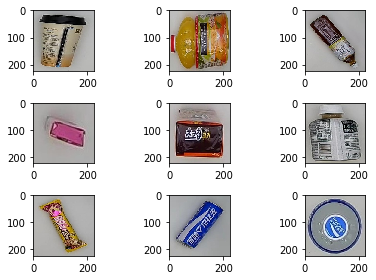

In [45]:
# plot sample data
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i, :, :, :])

plt.tight_layout()
plt.show()

In [5]:
def splitData(data, train_ratio=0.8):
    num_data = data.shape[0]
    num_train = int(num_data * train_ratio)
    
    train = data[:num_train]
    test = data[num_train:]
    
    return train, test

In [6]:
# split data into train, test
x_train, x_test = splitData(images, 0.8)

print("x_train shape :", x_train.shape)
print("x_test shape :", x_test.shape)

x_train shape : (1668, 224, 224, 3)
x_test shape : (417, 224, 224, 3)


In [30]:
# train
net = DeConvNet(lr=0.001)
history = net.fit(x_train, x_train, epochs=100, batch_size=16)

You are using GPU : /device:GPU:0 

Model Setting...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1-1 (Conv2D)             (None, 224, 224, 64)      1728      
_________________________________________________________________
batchnorm1-1 (BatchNormaliza (None, 224, 224, 64)      256       
_________________________________________________________________
relu1-1 (Activation)         (None, 224, 224, 64)      0         
_________________________________________________________________
conv1-2 (Conv2D)             (None, 224, 224, 64)      36864     
_________________________________________________________________
batchnorm1-2 (BatchNormaliza (None, 224, 224, 64)      256       
_________________________________________________________________
relu1-2 (Activation)   

In [31]:
# predict and feature

# net.save()
y_pred = net.predict(x_test)
feature = net.getFeature(x_test)

print("y_pred shape :", y_pred.shape)
print("feature shape :", feature.shape)

4.32 sec for prediction
2.29 sec for generating feature
y_pred shape : (417, 224, 224, 3)
feature shape : (417, 1, 1, 1024)


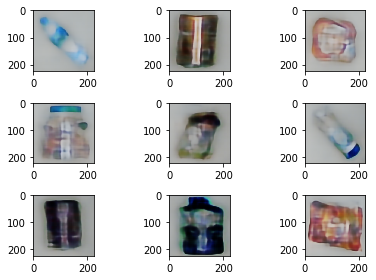

In [42]:
# plot sample data
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(y_pred[i+140, :, :, :])

plt.tight_layout()
plt.show()